In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv("./experiment/experiment_log.csv")

## CV-LBの相関

((0.5, 1.0), (0.5, 1.0))

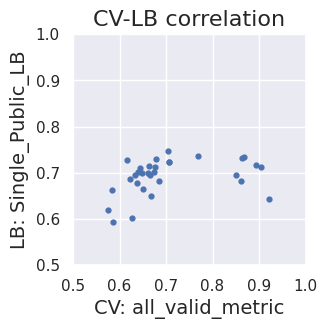

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), facecolor="white")

ax.scatter(df["all_valid_metric"], df["Single_Public_LB"], s=12)
ax.set_title("CV-LB correlation", fontsize=16)
ax.set_xlabel("CV: all_valid_metric", fontsize=14)
ax.set_ylabel("LB: Single_Public_LB", fontsize=14)
ax.set_xlim([0.5, 1]), ax.set_ylim([0.5, 1])

### バッチサイズとCV, LB
* 基本的にはケースバイケースだから考えるより試したほうが早そう
* 一般には低バッチ：計算コスト大 // 大バッチ：計算コスト小
* 低バッチほど1サンプルへの反応が良くなる ⇔ 過学習方向にいく？
* BERTなら「12k tokens per batch」
    * https://datascience.stackexchange.com/questions/104143/optimal-batch-size-and-number-of-epoch-for-bert
* そもそも論としてtrain_batchと比べるのはf1-scoreでいいんかい、という話もある
    * 直接にはLossを比較すべきでは？（Loss->f1でceil/floorの非線形変換が入っているので）
        * 絶対学習曲線を出す実装しといたほうがいいでしょ(笑)

In [4]:
tdf = df[
    (df["run_id"].map(lambda x: "batch" in x)) |
    (df["run_id"] == "roberta_large")
    ].copy()
tdf["train_batch_size"] = [32, 16, 64, 128, 256, 512, 8]
tdf = tdf.sort_values("train_batch_size", ascending=True)

fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(8, 4))

ax.set_xlim([0, 600])
ax.set_ylim([0, 1.1])
ax.plot(tdf["train_batch_size"], tdf["Single_Public_LB"], c="orange", marker="o")
ax.plot(tdf["train_batch_size"], tdf["all_valid_metric"], c="green", marker="v")
ax.plot(tdf["train_batch_size"], tdf["mean_valid_metric"], c="darkgray", marker="x")

ax.set_title("Stratified KFold = 5, train_batch vs f1-metrics", fontsize=18, pad=20)
ax.set_xlabel("train_batch_size", fontsize=16, labelpad=10)
ax.set_ylabel("metrics : f1-score[-]", fontsize=16, labelpad=10)

ax.text(500, 0.68, "Single Public LB", c="orange", fontsize=12, fontweight="semibold")
ax.text(520, 0.55, "all_valid_metric", c="green", fontsize=12, fontweight="semibold")
ax.text(500, 0.42, "mean_valid_metric", c="darkgray", fontsize=12, fontweight="semibold")

ValueError: Length of values (7) does not match length of index (25)

### fold数とCV, LB

* 「データ数が少ないので、CVの分割数を増やすと良いという仮説をたて、実験結果もそのとおりだった」
    * https://upura.hatenablog.com/entry/2021/08/08/182756 の9位
    * なんで？？？

Text(26, 0.8, 'mean_valid_metric')

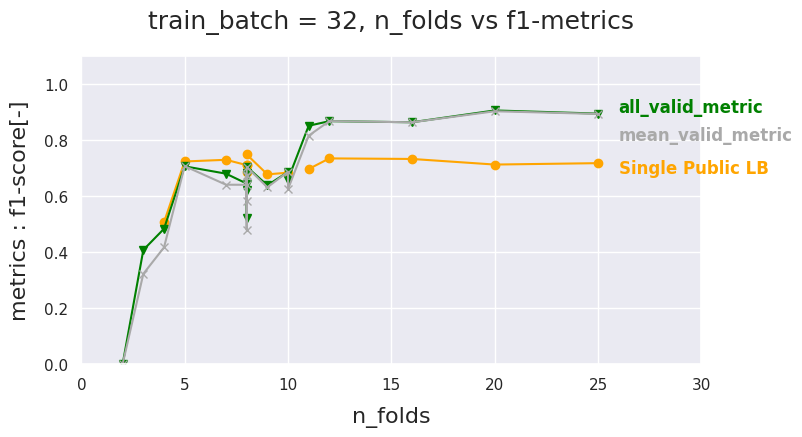

In [5]:
tdf = df.loc[df["run_id"].map(lambda x: "fold" in x or x == "roberta_large_cat4"), :].sort_values("folds")

fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(8, 4))

ax.set_xlim([0, 30])
ax.set_ylim([0, 1.1])
ax.plot(tdf["folds"], tdf["Single_Public_LB"], c="orange", marker="o")
ax.plot(tdf["folds"], tdf["all_valid_metric"], c="green", marker="v")
ax.plot(tdf["folds"], tdf["mean_valid_metric"], c="darkgray", marker="x")

ax.set_title("train_batch = 32, n_folds vs f1-metrics", fontsize=18, pad=20)
ax.set_xlabel("n_folds", fontsize=16, labelpad=10)
ax.set_ylabel("metrics : f1-score[-]", fontsize=16, labelpad=10)

ax.text(26, 0.68, "Single Public LB", c="orange", fontsize=12, fontweight="semibold")
ax.text(26, 0.9, "all_valid_metric", c="green", fontsize=12, fontweight="semibold")
ax.text(26, 0.8, "mean_valid_metric", c="darkgray", fontsize=12, fontweight="semibold")

### 再現性取れてなくない? --

In [15]:
t1 = df[df["run_id"] == "roberta_large_cat4"]
t2 = df[df["run_id"] == "compare_batch_accum_roberta_large_cat4_batch32"]

In [34]:
pd.DataFrame(df.columns)[~(t1.values == t2.values)[0]]

,0
0,Single_Public_LB
1,all_valid_metric
2,mean_valid_metric
3,run_id
5,output_path
24,remark
